As your homework, you will use a Cellcharter to compute the cellular neighborhood representation, and later - analyze them. The task is inspired by this tutorial, so we highly recommend to go through it before jumping into coding the solution.

Your task consists of the following step:

*   (warm up) - once again perform a PCA on cells marker expressions. Your PCA should explain 95% of markers variance. Store a PCA transformed marker expressions in train_anndata.obsm["X_PCA"] field (note: this is equivalent to "X_SCVI" field from the tutorial) - 1pt,
*   perform a cellcharter neighbor aggregation using this function (hint: sample_key for our data is sample_id). Select n_layers parameter value on your own, but shortly explain your choice - 2pts,

*   perform a cluster selection in the same manner as for mean marker and cell type histogram representation - 2pts,
*   perform a PCA, celltype abundance and mean marker analysis in the same manner as for mean marker and cell type histogram representations - 3pts,

*   for each pair of the clusterings out of mean marker, cell type histogram and cellcharter-based ones, compute a cross-count matrix (a cross-count matrix stores the information about how many times each cell was assigned to a predefined pair of clusters from every modality). Visualize these matrices and briefly explain the results - 2pts.


In this task you do not need to prepare a proper report, inline comments in the notebook are sufficient. However, make sure that you comment on any of the steps, decisions or results. As usual, we want to make sure that we are able to understand our results.

The deadline for the task: 12th May, 12:00 (noon) Have fun!


0. Data preparation

In [1]:
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
!pip uninstall numpy
!pip install numpy==1.23.4
!pip install anndata
!pip install squidpy
!pip install cellcharter

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.0.2.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e71.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 71.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.4 which is incompatible.
pandas-stubs 2.2.2.240909 requires numpy>=1.23.5, but you have numpy 1.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 123.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━

In [3]:
#Loading data
import anndata

TRAIN_ANNDATA_PATH = '/content/train_adata.h5ad'

train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

In [4]:
import squidpy as sq

train_anndata.obsm['spatial'] = train_anndata.obs[['Pos_X', 'Pos_Y']].values
sq.gr.spatial_neighbors(train_anndata, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


1. Warm up - perform a PCA on cells marker expressions. Your PCA should explain 95% of markers variance. Store a PCA transformed marker expressions in train_anndata.obsm["X_PCA"] field (note: this is equivalent to "X_SCVI" field from the tutorial) - 1pt,

In [5]:
from sklearn.preprocessing import normalize

#Extract marker expressions
X = train_anndata.layers['exprs']
expr_sums = train_anndata.layers['exprs'].sum(axis=1)

#Normalize marker expression data
X_normalized = X/expr_sums[:,np.newaxis] * 1e6

#Fit PCA to explain 95% of the variance
pca = PCA(n_components=0.95, svd_solver='full')
X_pca = pca.fit_transform(X_normalized)

#Store PCA-transformed data
train_anndata.obsm['X_PCA'] = X_pca

# Optional: Check number of components
print(f"PCA retained {pca.n_components_} components to explain 95% variance.")


PCA retained 24 components to explain 95% variance.


<Figure size 1000x700 with 0 Axes>

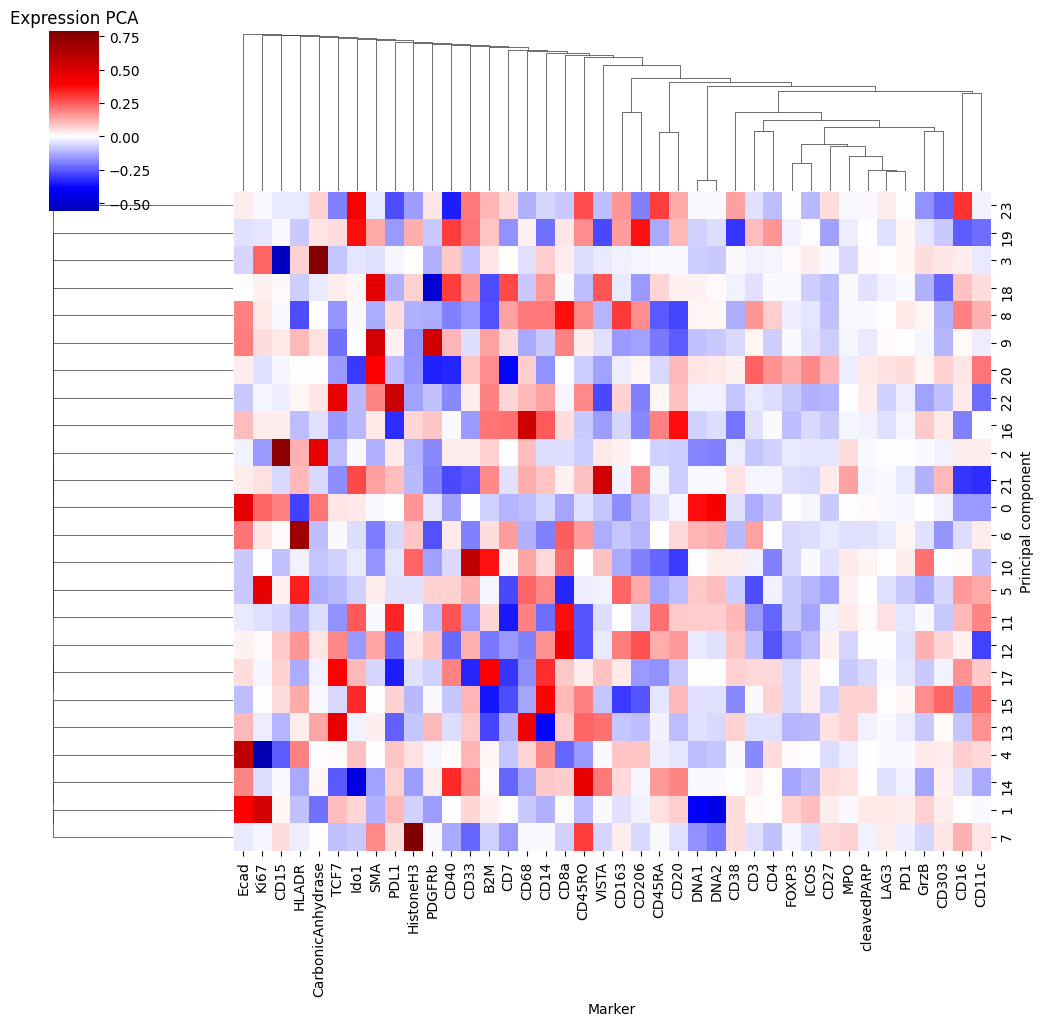

In [6]:
#Visualization of the PCA
marker_names = train_anndata.var['marker']

plt.figure(figsize = (10, 7))
g = sns.clustermap(pca.components_, center = 0, cmap = 'seismic', xticklabels = marker_names)
g.ax_heatmap.set_xlabel('Marker')
g.ax_heatmap.set_ylabel('Principal component')
plt.title('Expression PCA')
plt.show()

2. Perform a cellcharter neighbor aggregation using this function (hint: sample_key for our data is sample_id). Select n_layers parameter value on your own, but shortly explain your choice

In [7]:
#Neighbor aggregation
import cellcharter as cc

cc.gr.aggregate_neighbors(
    train_anndata,
    n_layers=2,
    use_rep='X_PCA',
    sample_key = 'sample_id'
)

  0%|          | 0/132 [00:00<?, ?it/s]

Number of layers equals 2, so that it will give a rich local context without a rist of blurring distinct regions as higher numbers could do. 2 layers keeps the balance between local detail and broader structure.

3. Perform a cluster selection in the same manner as for mean marker and cell type histogram representation - 2pts,

In [8]:
import scanpy as sc
import cellcharter as cc
import torch  # Check if GPU is available for Cellcharter
import seaborn as sns
import matplotlib.pyplot as plt

#Defining model parameters
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu',
            'enable_progress_bar': False
        },
    }

#Finding a number of clasters with AutoK
models_for_clasters = cc.tl.ClusterAutoK(n_clusters=(10,30), model_class=cc.tl.GaussianMixture,
                            model_params=model_params, max_runs=5)


In [10]:
#Changing data type to float32
train_anndata.obsm["X_cellcharter"] = train_anndata.obsm["X_cellcharter"].astype(np.float32)
#Running AutoK
models_for_clasters.fit(train_anndata, use_rep='X_cellcharter')


Iteration 1/5


  0%|          | 0/23 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=17` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/23 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=17` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/23 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=17` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/23 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=17` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/23 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=17` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

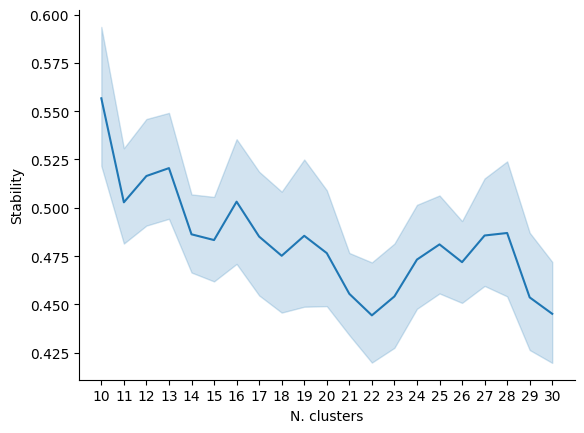

In [11]:
#Visual representation of the fitted model
cc.pl.autok_stability(models_for_clasters)

In [12]:
#Adding results of the prediction with the best number of clasters to anndata
train_anndata.obs['clusters_cellcharter'] = models_for_clasters.predict(train_anndata, use_rep='X_cellcharter', k=models_for_clasters.best_k)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


4. Perform a PCA, celltype abundance and mean marker analysis in the same manner as for mean marker and cell type histogram representations - 3pts,

PCA histogram for each cluster

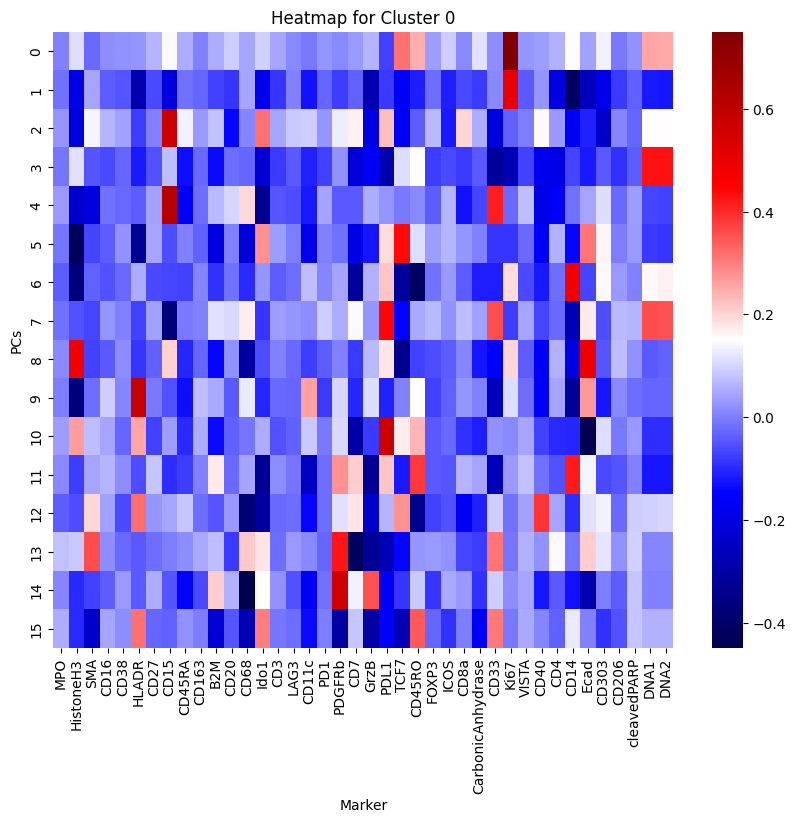

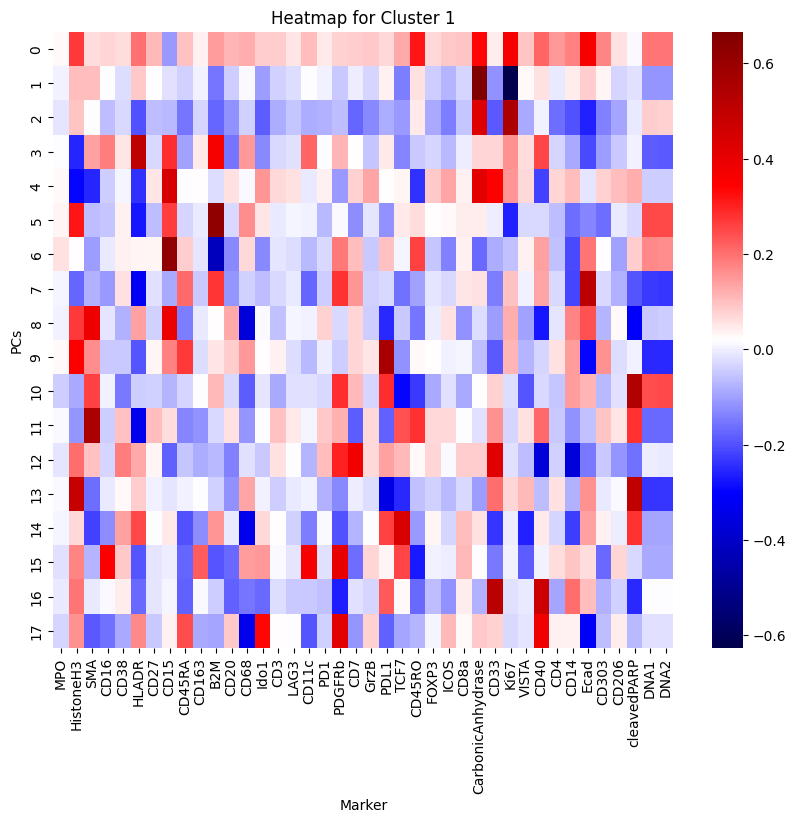

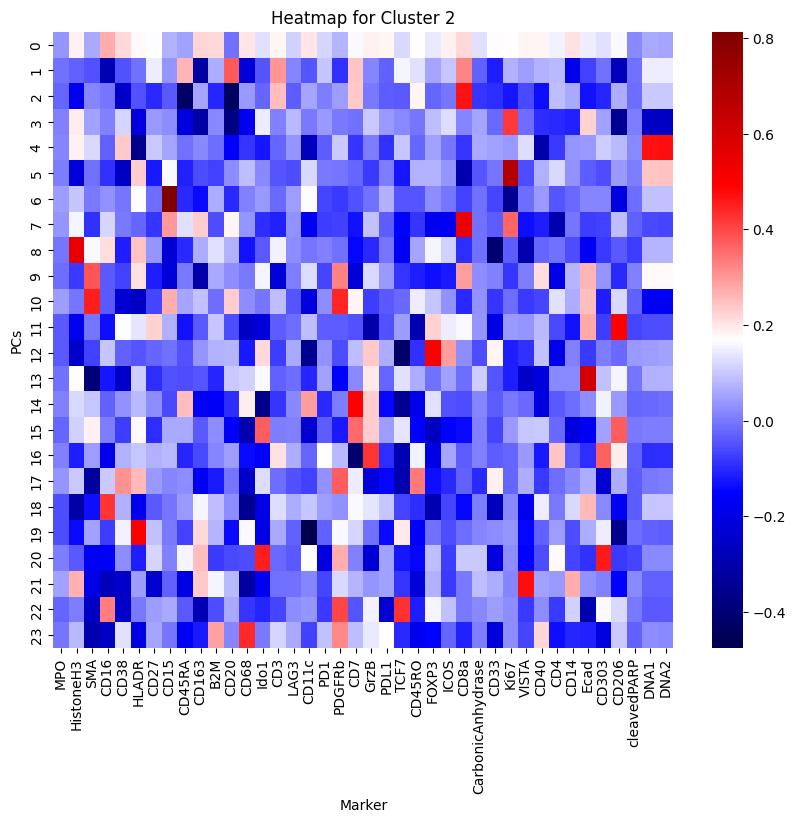

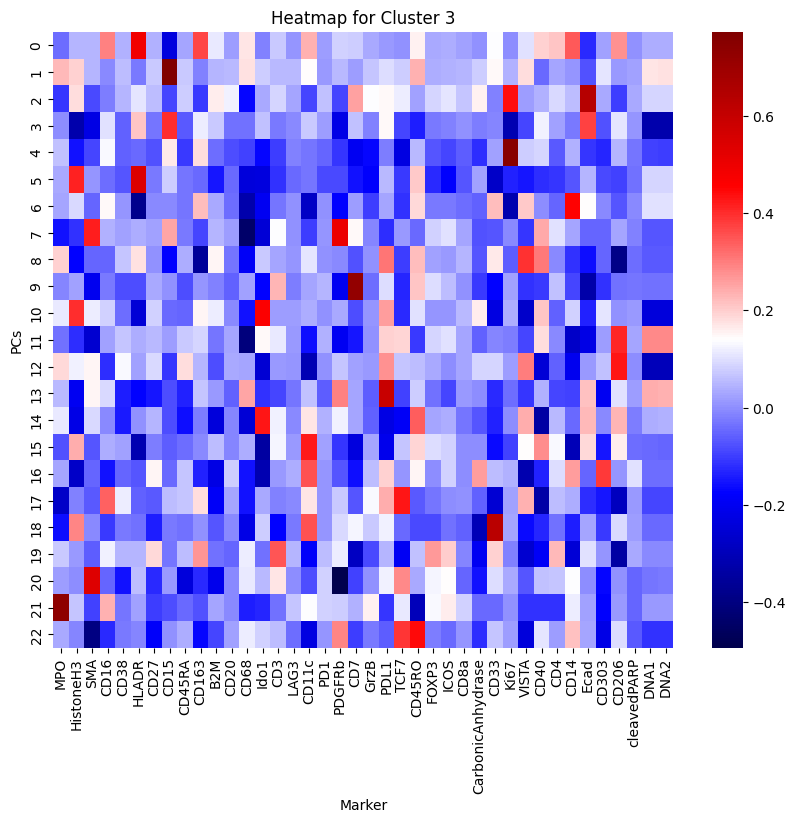

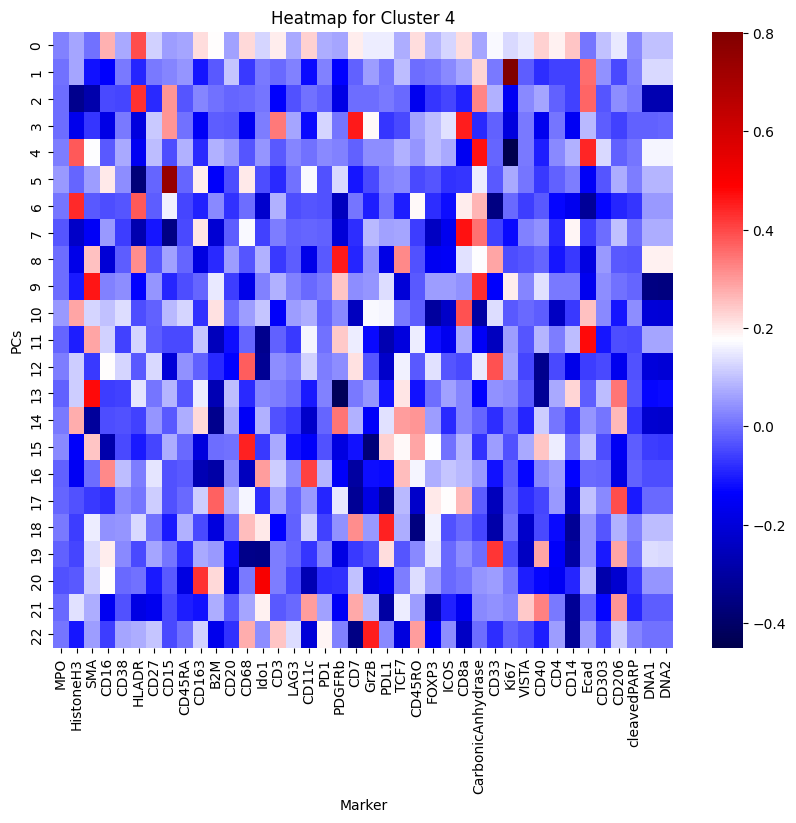

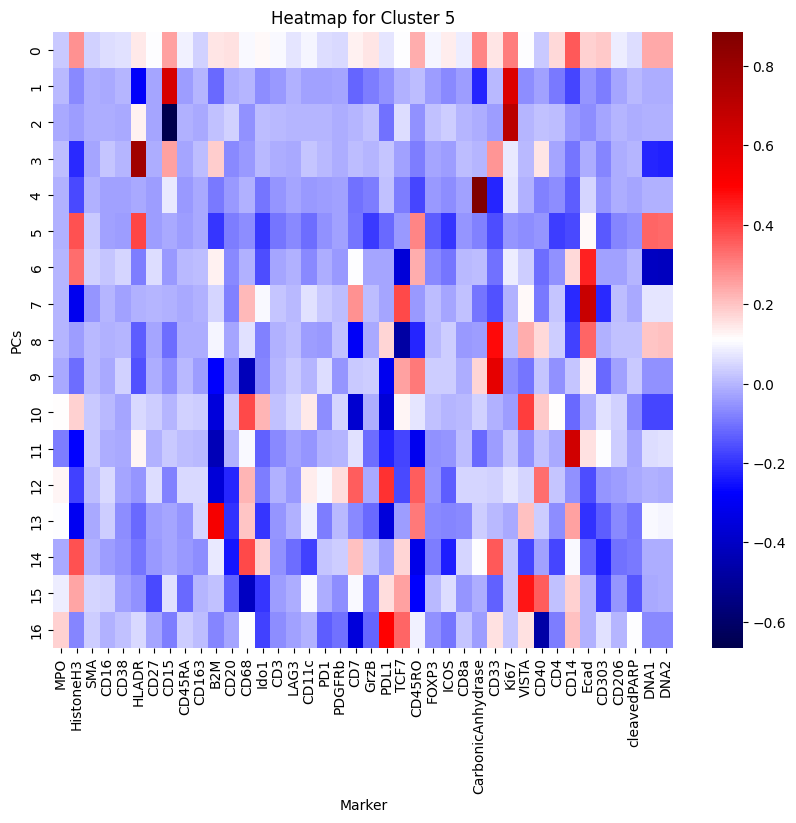

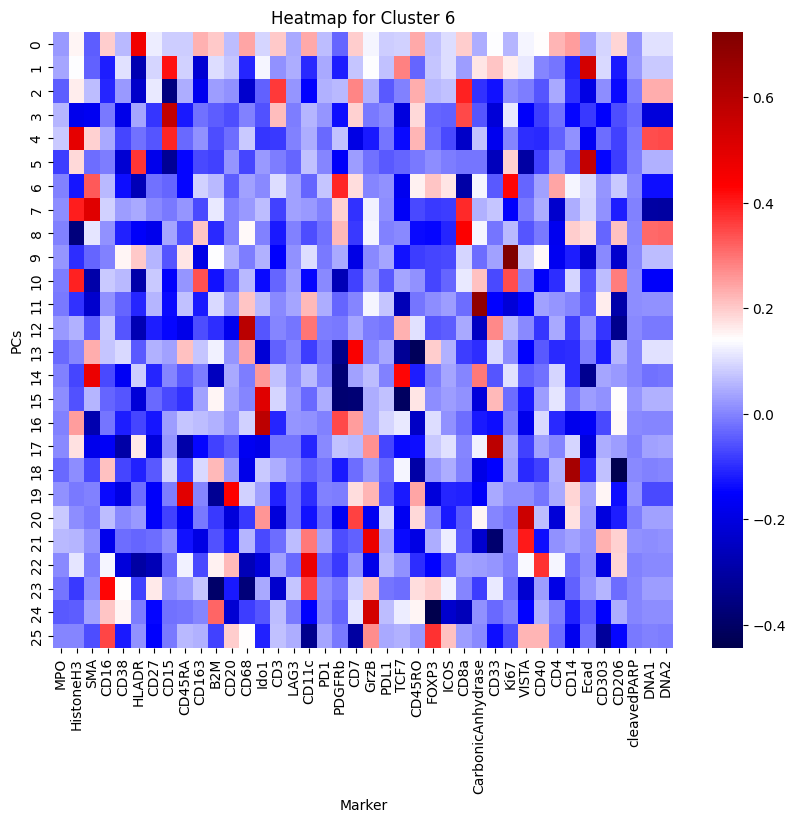

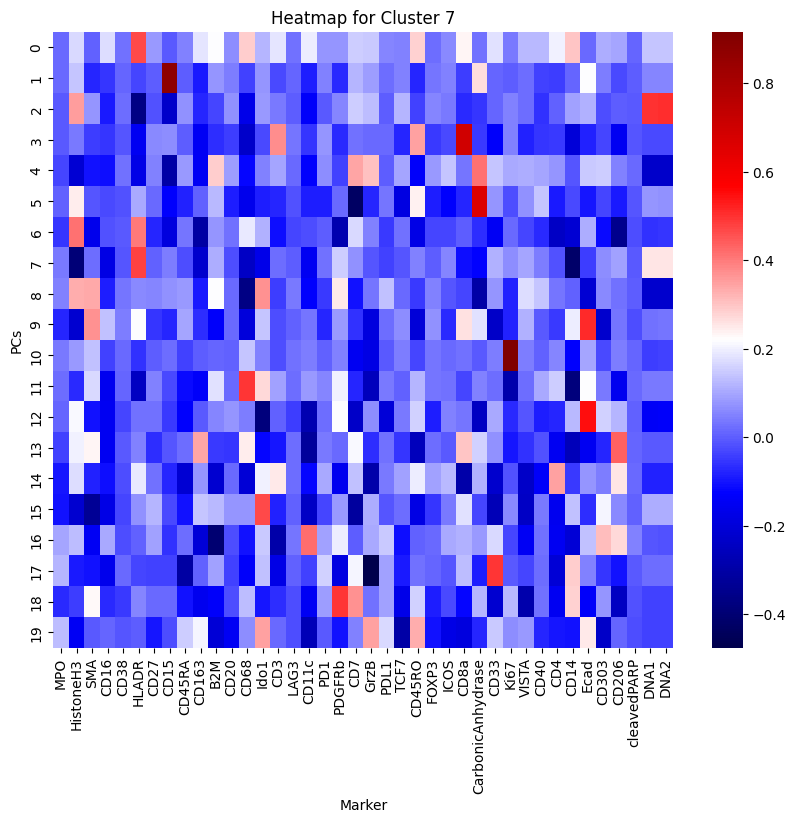

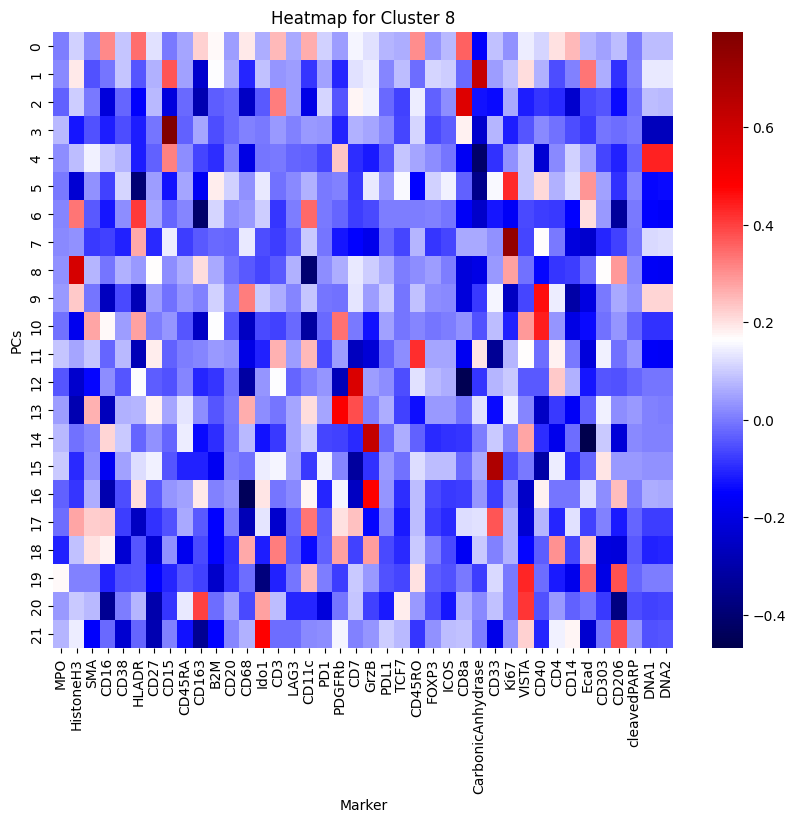

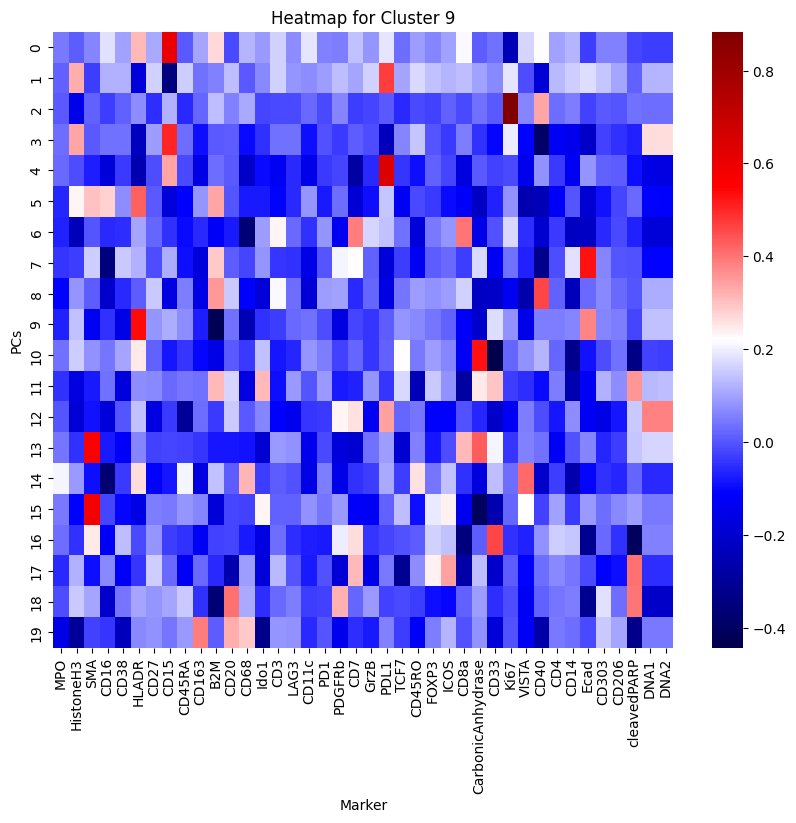

In [13]:
#PCA for each cluster
for i in range(models_for_clasters.best_k):
  mask = train_anndata.obs['clusters_cellcharter'] == i

  cluster_exprs = train_anndata.layers['exprs'][mask,:]
  pca = PCA(n_components = 0.95)
  cluster_exprs_pca = pca.fit_transform(cluster_exprs)

  plt.figure(figsize=(10, 8))
  sns.heatmap(pca.components_, cmap="seismic", xticklabels=train_anndata.var['marker'])  # Choose an appropriate colormap
  plt.title(f'Heatmap for Cluster {i}')
  plt.xlabel('Marker')
  plt.ylabel('PCs')
  plt.show()




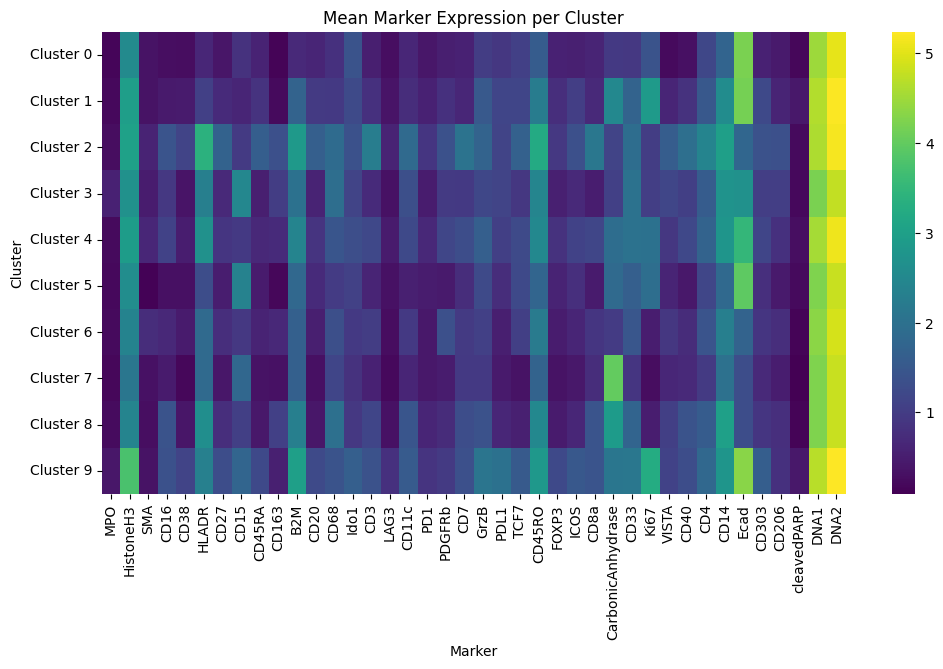

In [14]:
#Computing mean marker expression for each cluster
mean_marker_exprs = []

for i in range(models_for_clasters.best_k):
    mask = train_anndata.obs['clusters_cellcharter'] == i
    cluster_exprs = train_anndata.layers['exprs'][mask]
    mean_expr = cluster_exprs.mean(axis=0)
    mean_marker_exprs.append(mean_expr)

mean_marker_exprs = np.vstack(mean_marker_exprs)

#Heatmap of the results
plt.figure(figsize=(12, 6))
sns.heatmap(mean_marker_exprs, cmap='viridis', xticklabels=train_anndata.var['marker'], yticklabels=[f"Cluster {i}" for i in range(models_for_clasters.best_k)])
plt.title("Mean marker expression per Cluster")
plt.xlabel("Marker")
plt.ylabel("Cluster")
plt.show()


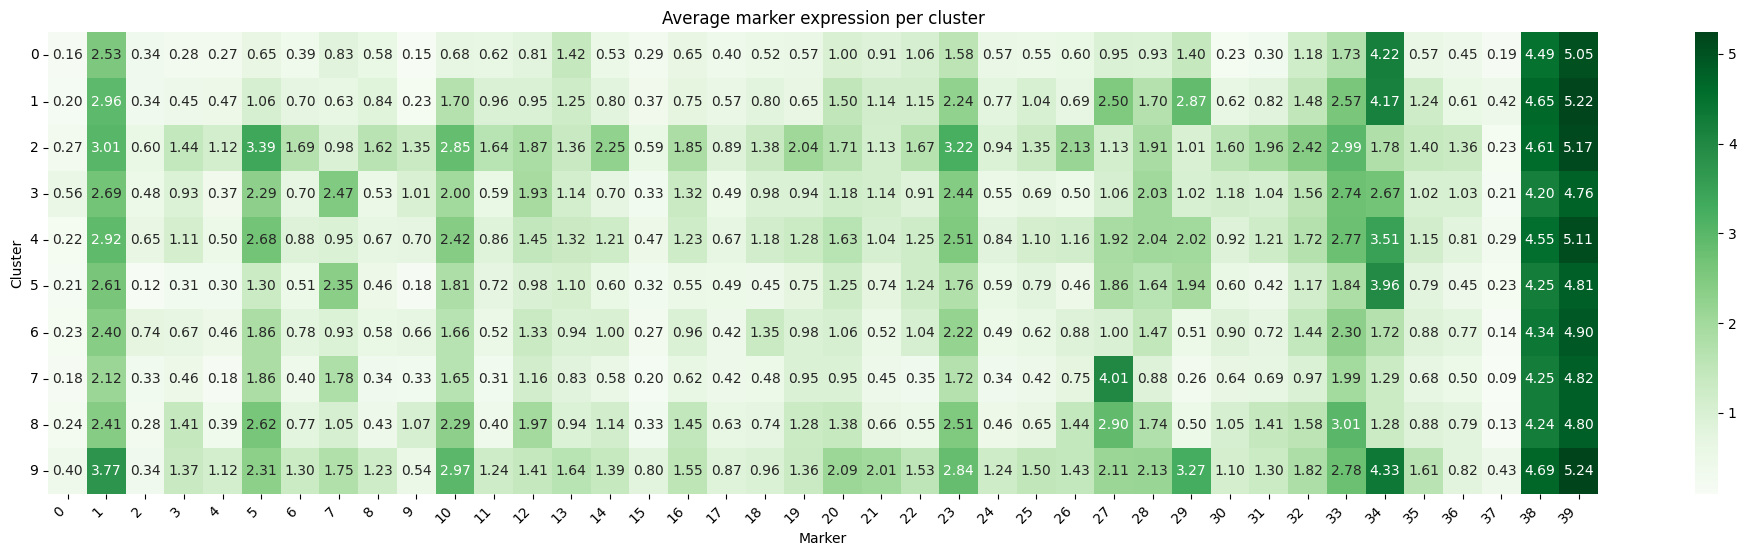

In [20]:
plt.figure(figsize=(25,6))
sns.heatmap(mean_marker_exprs, annot=True, fmt='.2f', cmap="Greens")

plt.title('Average marker expression per cluster')
plt.xlabel('Marker')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

Celltype abundance

<ipython-input-17-74d9a4a9bbe3>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  celltype_abundance = train_anndata.obs.groupby(['clusters_cellcharter', 'celltypes']).size().unstack()


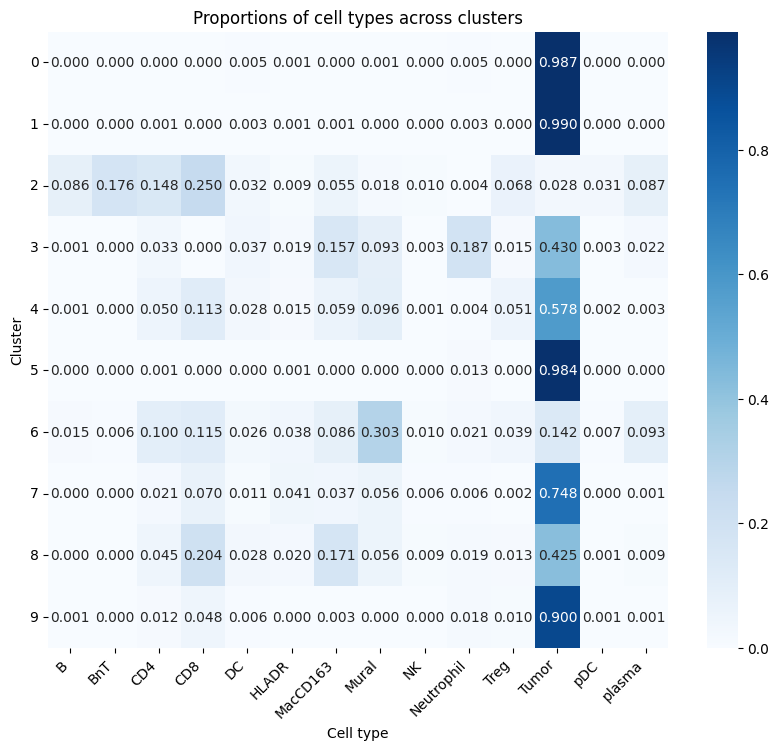

In [17]:
#Celltype abundance
celltype_abundance = train_anndata.obs.groupby(['clusters_cellcharter', 'celltypes']).size().unstack()

celltype_avg_abundance = celltype_abundance.div(celltype_abundance.sum(axis=1), axis=0)
celltype_avg_abundance

#Visualizing the results
plt.figure(figsize=(10,8))
sns.heatmap(celltype_avg_abundance, annot=True,fmt='.3f', cmap="Blues")

plt.title('Proportions of cell types in clusters')
plt.xlabel('Cell type')
plt.ylabel('Cluster')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

The tumor cells are present in almost every cluster. We should expect these results, because the data we analyze is collected from cancer patients.


5. For each pair of the clusterings out of mean marker, cell type histogram and cellcharter-based ones, compute a cross-count matrix (a cross-count matrix stores the information about how many times each cell was assigned to a predefined pair of clusters from every modality). Visualize these matrices and briefly explain the results - 2pts.

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cross_count_matrix(clusters1, clusters2, name1, name2):
    """
    Computes and plots a cross-count matrix between two cluster assignments.

    Args:
        clusters1: Series or array of cluster labels for method 1
        clusters2: Series or array of cluster labels for method 2
        name1: Label/name for method 1
        name2: Label/name for method 2
    """
    cross_counts = pd.crosstab(clusters1, clusters2)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_counts, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Cross-Count Matrix: {name1} vs {name2}")
    plt.xlabel(name2)
    plt.ylabel(name1)
    plt.tight_layout()
    plt.show()

    return cross_counts

# Run the comparisons

# Mean Marker vs Cell Type Histogram
cc_mm_vs_ct = plot_cross_count_matrix(
    mean_marker_exprs,
    celltype_avg_abundance,
    "Mean Marker", "Cell Type Histogram"
)

# Mean Marker vs CellCharter
cc_mm_vs_cc = plot_cross_count_matrix(
    mean_marker_exprs,
    train_anndata.obs['clusters_cellcharter'],
    "Mean Marker", "CellCharter"
)

# Cell Type Histogram vs CellCharter
cc_ct_vs_cc = plot_cross_count_matrix(
    celltype_avg_abundance,
    train_anndata.obs['clusters_cellcharter'],
    "Cell Type Histogram", "CellCharter"
)


ValueError: operands could not be broadcast together with shapes (10,40) (1,10,14) 